# Linear Dynamical System

In [1]:
import logging
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.INFO)  # set level to INFO for wordy
import matplotlib.pyplot as plt
from IPython.display import HTML

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS

from extravaganza.controllers import LiftedBPC
from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LQR, HINF, BPC, GPC, RBPC
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from extravaganza.utils import ylim, render
from extravaganza.experiments import Experiment

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 17
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we work with a Linear Dynamical System (LDS) with various types of perturbations.

The states $\{x_t\}_{t}$ evolve with
$$x_{t+1} = A x_{t} + B u_t + w_t,$$
where $A$ and $B$ are randomly generated dynamics, $u_t$ is the input control, and $w_t$ is the output of one of the below disturbance schedules.

The costs are denoted by $f(x_t, u_t)$ and given by the below cost functions.

INFO: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'
INFO: Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


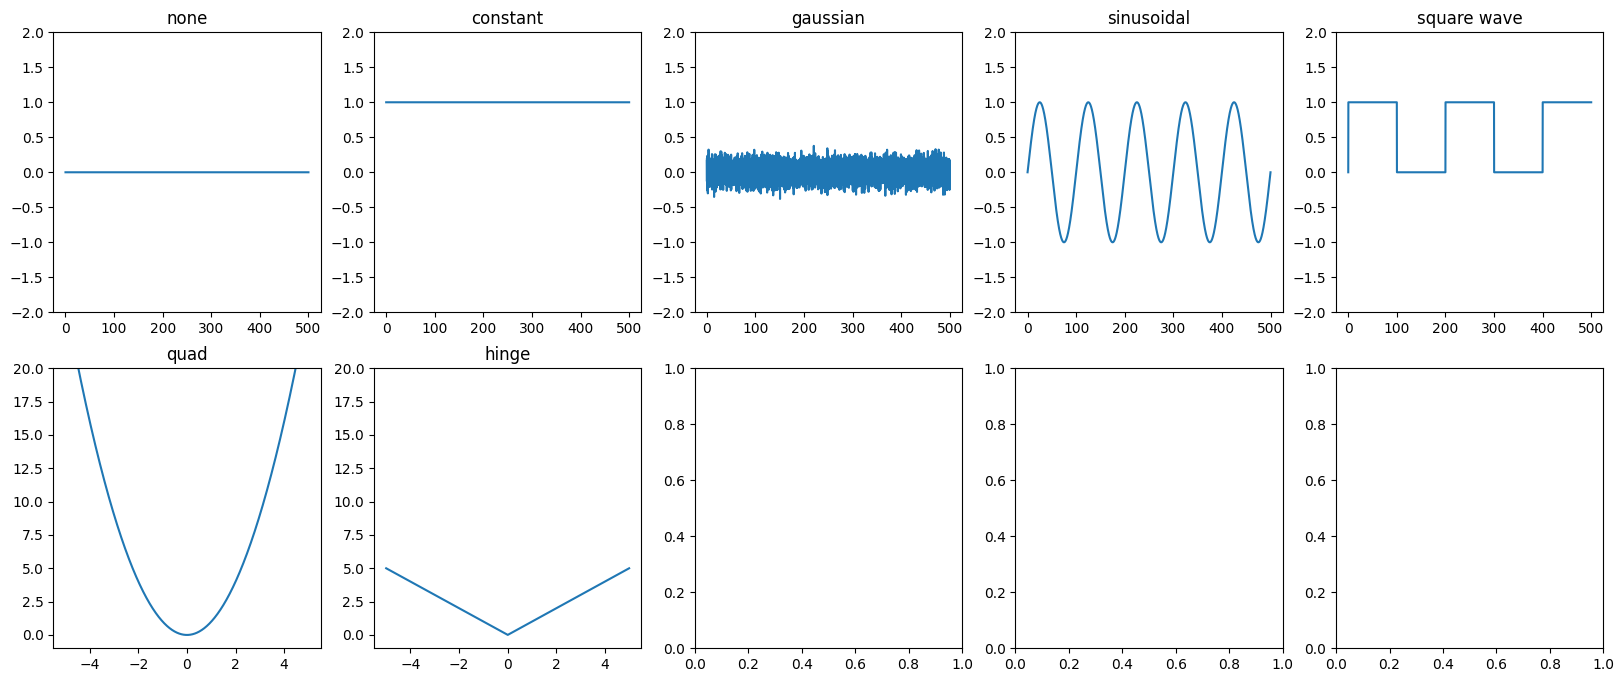

In [2]:
disturbance_fns = {'none': lambda t: 0.,
                   'constant': lambda t: 1.,
                   'gaussian': lambda t: np.random.randn() * 0.1,  # variance of 0.01
#                    'linear': lambda t: float(t),  # this one is stupid
                   'sinusoidal': lambda t: np.sin(2 * np.pi * t / 100),  # period of 100 steps
                   'square wave': lambda t: np.ceil(t / 100) % 2  # period of 40
                  }

cost_fns = {'quad': lambda x, u: jnp.dot(x, x) + jnp.dot(u, u),
            'hinge': lambda x, u: jnp.sum(jnp.abs(x)) + jnp.sum(jnp.abs(u))}

num_points = 10000
fig, ax = plt.subplots(2, len(disturbance_fns), figsize=(4 * len(disturbance_fns), 8))
for i, (k, fn) in enumerate(disturbance_fns.items()):
    xs = np.linspace(0, 500, num_points)
    ax[0, i].plot(xs, [fn(t) for t in xs])
    ax[0, i].set_ylim(-2, 2)
    ax[0, i].set_title(k)
for i, (k, fn) in enumerate(cost_fns.items()):
    xs = np.linspace(-5, 5, num_points)
    ax[1, i].plot(xs, [fn(t, 0) for t in xs])
    ax[1, i].set_ylim(-1, 20)
    ax[1, i].set_title(k)    
plt.show()

## Hyperparameters

In [3]:
name = 'lds_squarewave'
filename = '../logs/{}.pkl'.format(name)

def get_experiment_args():
    # --------------------------------------------------------------------------------------
    # ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    num_trials = 1
    T = 15000  # total timesteps
    T0 = 10000  # number of timesteps to just sysid for our methods
    reset_condition = lambda t: False  # how often to reset the system
    use_multiprocessing = False
    render_every = None

    # --------------------------------------------------------------------------------------
    # --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
    # --------------------------------------------------------------------------------------

    du = 1  # control dim
    ds = 1  # state dim

    disturbance_type = 'square wave'
    cost_fn = 'quad'

    make_system = lambda : LDS(ds, du, disturbance_type, cost_fn, seed=SYSTEM_SEED)

    # --------------------------------------------------------------------------------------
    # ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    sysid_method = 'regression'
    sysid_scale = 0.3

    learned_lift_args = {
        'lift_lr': 0.01,
        'sysid_lr': 0.01,
        'cost_lr': 0.001,
        'depth': 6,
        'buffer_maxlen': int(1e6),
        'num_epochs': 100,
        'batch_size': 64,
        'seed': LIFTER_AND_SYSID_SEED
    }

    # --------------------------------------------------------------------------------------
    # ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
    # --------------------------------------------------------------------------------------

    h = 30  # controller memory length (# of w's to use on inference)
    hh = 30  # history length of the cost/control histories
    lift_dim = 30  # dimension to lift to

    m_update_rescaler = lambda : ADAM(0.003, betas=(0.9, 0.999))
    m0_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))
    k_update_rescaler = lambda : ADAM(0.00, betas=(0.9, 0.999))

    lifted_bpc_args = {
        'h': h,
        'method': 'REINFORCE',
        'initial_scales': (0.01, 0.1, 0.01),  # M, M0, K   (uses M0's scale for REINFORCE)
        'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
        'T0': T0,
    #     'bounds': None,
        'initial_u': jnp.zeros(du),
        'decay_scales': False,
        'use_tanh': False,
        'use_K_from_sysid': False,
        'seed': CONTROLLER_SEED
    }

    make_controllers = {
        'LQR': lambda sys: LQR(sys.A, sys.B, jnp.eye(ds), sys.R, seed=CONTROLLER_SEED),
        'HINF': lambda sys: HINF(sys.A, sys.B, jnp.eye(ds), sys.R, T=T, seed=CONTROLLER_SEED),
        'GPC': lambda sys: GPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.01, decay=True, seed=CONTROLLER_SEED),
        'BPC': lambda sys: BPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.01, decay=True, delta=0.001, seed=CONTROLLER_SEED),
        'RBPC': lambda sys: RBPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, M=h, lr=0.01, delta=0.001, noise_sd=0.05, seed=CONTROLLER_SEED),

        'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    #     'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
        'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
    }
    experiment_args = {
        'make_system': make_system,
        'make_controllers': make_controllers,
        'num_trials': num_trials,
        'T': T,
        'reset_condition': reset_condition,
        'reset_seed': SYSTEM_SEED,
        'use_multiprocessing': use_multiprocessing,
        'render_every': render_every,
    }
    return experiment_args

## actually run the thing :)

In [4]:
# run
experiment = Experiment(name)
stats = experiment(get_experiment_args)

INFO: (EXPERIMENT) --------------------------------------------------
INFO: (EXPERIMENT) ----------------- TRIAL 0 -----------------------
INFO: (EXPERIMENT) --------------------------------------------------

INFO: (EXPERIMENT): testing LQR
INFO: (LDS): initial state is [-1.9041343]
 19%|█████████████▌                                                        | 2897/15000 [00:02<00:09, 1226.78it/s, state=0, control=0, cost=0]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 51%|█████████████████████████████▉                             | 7625/15000 [00:06<00:07, 1029.26it/s, state=1.08, control=0.0822, cost=1.18]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in ord

In [5]:
# # save args and stats!  --  note that to save the args, we actually save the `get_args` function. we can print the 
# #                           source code later to see the hyperparameters we chose
# experiment.save(filename)

## Visualization
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [6]:
def plot_lds(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            logging.warning('{} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[3, 1], 'us', label=method)
        if 'costs' in stats:
            stats.plot(ax[1, 0], 'avg costs', label=method)
            stats.plot(ax[1, 1], 'costs', label=method)
        else:
            stats.plot(ax[1, 0], 'avg fs', label=method)
            stats.plot(ax[1, 1], 'fs', label=method)
    
        stats.plot(ax[2, 0], '||A||_op', label=method)
        stats.plot(ax[2, 1], '||B||_F', label=method)
        stats.plot(ax[3, 0], '||A-BK||_op', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend()
    _ax = ax[1, 0]; _ax.set_title('avg costs'); _ax.legend()
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend()
    
    _ax = ax[2, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('controls'); _ax.legend()
    pass

### Plot

<Figure size 640x480 with 0 Axes>

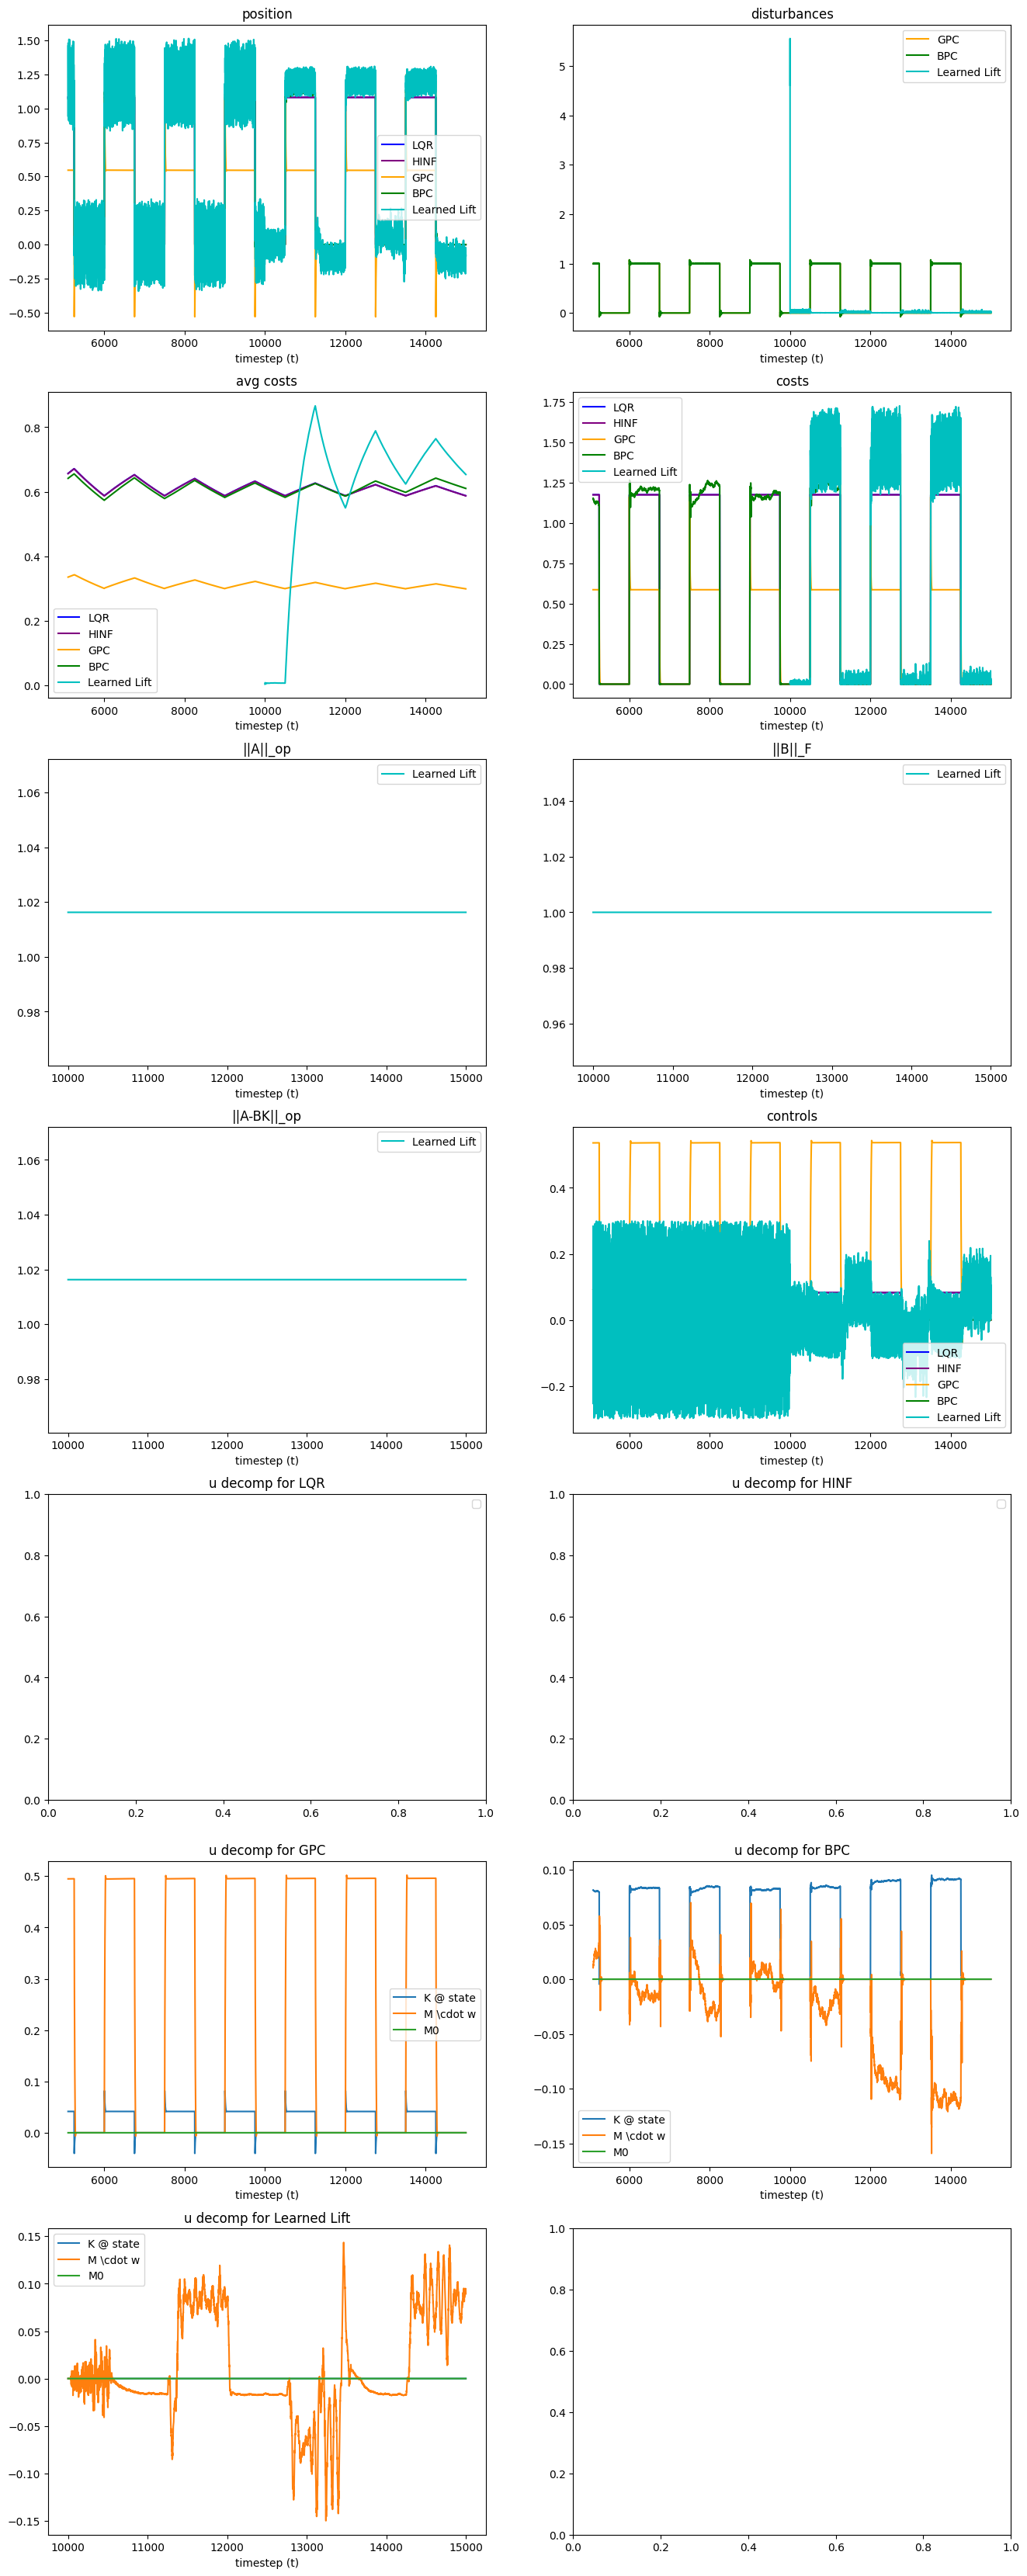

In [ ]:
# plot
from copy import deepcopy
e = deepcopy(experiment)
e.stats = {k: s[5100:] for k, s in e.stats.items() if k not in ['No Lift', 'RBPC']}
plot_lds(e)

### Dynamic Plot

In [ ]:
# dynamic plot
anim = render(experiment, 'xs', 'fs', sliderkey='us', save_path=None, duration=5, fps=30)
vid = anim.to_html5_video()
HTML(vid)

INFO: (RENDERER): rendering the stats of the following: ['LQR', 'HINF', 'GPC', 'BPC', 'RBPC', 'No Lift', 'Learned Lift']
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: (STATS): prepared to render ('xs', 'fs') over time with slider us!
INFO: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -r 29.999999999999996 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/5m/0xr906c130vdqvkm3g21n6wr0000gn/T/tmpwbxbtviv/temp.m4v
/Users/evandigiorno/Desktop/extravaganza/env/